In [1]:
import cobra
from cobra.sampling import sample
from cobra.sampling import OptGPSampler
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
#from matplotlib.patches import Patch
#from matplotlib import colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
import seaborn as sns
import os
from functools import partial
from cameo import fba
from collections import defaultdict
from cameo import phenotypic_phase_plane
import pickle
from statistics import mean
import lzma

In [2]:
def create_rxn(model, name, cpd_dict, direction="both", limits=None):
    # Create a reaction from a dict with {"CPD1": -1, "CPD2: 1"}
    # Assuming the cpd ids are already in the model
    if direction not in ["forward", "reverse", "both"]:
        raise ValueError("Direction must be either forward, reverse, or both")
    rxn = cobra.Reaction(name)
    if limits is not None:
        if len(limits) != 2:
            raise ValueError("Limits must be of length 2")
        else:
            rxn.lower_bound = limits[0]
            rxn.upper_bound = limits[1]
    elif direction == "both":
        rxn.lower_bound = -1000
        rxn.upper_bound = 1000
    elif direction == "forward":
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
    else:
        rxn.lower_bound = -1000
        rxn.upper_bound = 0
    rxn.add_metabolites({
        getattr(model.metabolites, cpd): val for cpd, val in cpd_dict.items()
    })
    print("Adding the following reaction to model:")
    print(rxn)
    model.add_reactions([rxn])
def multisample(model, n, runs=5, threads=1):
    n_per_run = int(n/runs)
    if n_per_run*runs != n:
        print("Note: specified number of samples is not divisible by number of runs")
    print("Collecting {r} samples of size {x}, for {y} total samples".format(r=runs, x=n_per_run, y=runs*n_per_run))
    #p = Pool(nodes=threads)
    #result = p.uimap(partial(sample, processes=1), (model,)*runs, (n_per_run,)*runs)
    #p.close()
    #p.join()
    #p.clear()
    result = []
    for i in range(runs):
        s = sample(model, n_per_run, processes=threads)
        result.append(s)
    return pd.concat(result, axis=0).reset_index()
def add_fixed_constraint(model, rxn, value):
    """
    model = cobra formatted model
    rxn = string of reaction id
    value = a single int/float to constrain the reaction to, or a list/tuple like (lb, ub)
    """
    try:
        lower = value[0]
        upper = value[1]
    except (TypeError, IndexError):
        lower = value
        upper = value
    constraint = model.problem.Constraint(
        getattr(model.reactions, rxn).flux_expression,
        lb=lower, ub=upper)
    model.add_cons_vars(constraint)
    return constraint
def mannwhitney_test_columns(df1, df2, decimals=4):
    """
    Compares all columns that are shared between two dataframes
    outputs p value from mannwhitney U test and the effect size as cohen's d: (u2 - u1)/stdev
    """
    rxn_list = set(df1.columns.values).intersection(set(df2.columns.values))
    sig_test_out = {}
    statistic_out = {}
    median1 = {}
    median2 = {}
    effect_size = 0
    dfs_rounded = [df.round(decimals) for df in [df1, df2]]
    for rxn in rxn_list:
        arrays = [df[rxn] for df in dfs_rounded]
        median1[rxn] = arrays[0].median()
        median2[rxn] = arrays[1].median()
        if np.concatenate(arrays).var().round(decimals) == 0:
            sig_test_out[rxn] = 1
            statistic_out[rxn] = 0
        else:
            test = mannwhitneyu(*arrays)
            sig_test_out[rxn] = test.pvalue
            #statistic_out[rxn] = norm.isf(test.pvalue/2)/sqrt(len(arrays[0]))
            statistic_out[rxn] = (arrays[1].mean() - arrays[0].mean())/arrays[0].std()
    df = pd.concat([pd.Series(sig_test_out), pd.Series(statistic_out), pd.Series(median1), pd.Series(median2)], axis=1)
    df.columns = ["pvalue", "effect_size", "median1", "median2"]
    return df

### Preparation
The code below assumes:
1. The code is being run from the GEM-iCbes/manuscript directory

In [3]:
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"

### SBML file generation
SBML files were generated from psamm using the `psamm-model sbmlexport` command.

In the open model, the following constraints were added to limits.yaml:
```
- reaction: R00700
  lower: 0
  upper: 0
- reaction: R07181
  lower: 0
  upper: 0
```

In the closed model, the constraints were as follows:
```
- reaction: R00700
  lower: 0
  upper: 1000
- reaction: R07181
  lower: 0
  upper: 1000
```

In [4]:
with open("../sbmls/b971180d_YM_closed.sbml") as f:
    YM_closed = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_open.sbml") as f:
    YM_open = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_CODH_closed.sbml") as f:
    CODH_closed = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_CODH_open.sbml") as f:
    CODH_open = cobra.io.read_sbml_model(f)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


## Universal constraints
1. GAPDH is removed in glycolytic conditions
2. GAPOR is removed in gluconeogenic conditions

In [5]:
for model in [YM_closed, YM_open, CODH_closed, CODH_open]:
    model.reactions.R01061.upper_bound = 0
    model.reactions.R01063.upper_bound = 0

## Calibrate overexpression for 'open' and 'closed' models
See 'calibrate_OE-AdhF.ipynb' for the calibration and sampling of open and closed models.
In that notebook, samples were collected for the COM1c genotype in open and closed systems with the control and OE-AdhF expression levels used to constrain ethanol production.

For figure 3, we use additional simulations for the OE-AdhF Δ*aor* and the OE-AdhF CODH strains. OE-AdhF Δ*aor* simulations are repurposed from the gene knockout analysis (Figure 6), therefore, this notebook requires that the knockout analysis has already been run. The OE-AdhF CODH and Control samples are the only samples collected in this notebook.

#### Recovering samples
Run these to instantly load the samples from the manuscript.
This allows you to skip the 'multisample' blocks, which take a few minutes to run

In [6]:
with lzma.open("pickles/s1.pkl.xz", "rb") as f:
    s1_closed, s1_open, s1_YM_closed_OE, s1_YM_open_OE = pickle.load(f)

In [7]:
with lzma.open("pickles/s2.pkl.xz", "rb") as f:
    s_MW004_closed, s_CODH_100 = pickle.load(f)

### Figure 3
Comparison of modeled ethanol:acetate ratios to experimental measurements

In [8]:
data_path = "b971180d/combined.tsv"
df = pd.read_csv(data_path, sep="\t")
df["Closed"] = [("closed" in x) for x in df.Source]
df["Source"] = df.Source.str.replace("_closed", "")
df["Source"] = df.Source.str.replace("_open", "")
df["Knockins"] = [x.split("d")[0] for x in df.Source]
df["deletions"] = [x.split("d")[1] for x in df.Source]
### 
yaxisname = "Scaled production flux"
df = df.drop(columns=["Biomass", "MalABC", "Source"]).rename(columns={"TP_ace": "Acetate", "TP_ETOH": "Ethanol"})
df = df.melt(["Knockins","deletions", "Closed"], value_name=yaxisname)
df.deletions = ["Δ" + x.replace("_", " Δ").replace(".csv", "") for x in df.deletions]
df.loc[[x == "Δ" for x in df.deletions]] = df.loc[[x == "Δ" for x in df.deletions]].assign(deletions="No deletions")
df.Knockins = ["+"+x.rstrip("_YM_").replace("_", " +") for x in df.Knockins]
df.loc[df.Knockins == "+"] = df.loc[df.Knockins == "+"].assign(Knockins="None")
df = df[[("NFN1" not in x) or (x == "ΔGAPOR ΔNFN1") for x in df.deletions]] # filter NFN1 strains bc we don't talk about them
## axis sorting order
l = list(set(df.deletions))
l.sort(key=len)
l.insert(0, l.pop(l.index("No deletions")))
l.insert(3, l.pop(l.index("ΔMBH")))
MW647 = df[(df["Knockins"] == "None") & (df.deletions == "ΔAOR")]
MW647_closed = MW647[MW647["Closed"]]
etoh = MW647_closed[MW647_closed["variable"] == "Ethanol"]["Scaled production flux"].to_numpy()
ace = MW647_closed[MW647_closed["variable"] == "Acetate"]["Scaled production flux"].to_numpy()

**Skip if you loaded the samples above**

In [84]:
YM_closed_Control = YM_closed.copy()
YM_closed_Control.reactions.TP_ETOH.upper_bound = np.quantile(s1_closed.TP_ETOH, 0.75)
s_MW004_closed = multisample(YM_closed_Control, 2500, runs=10, threads=4)

**Skip if you loaded the samples above**

In [98]:
CODH_100 = CODH_closed.copy()
CODH_100.reactions.CODH.upper_bound = 1000
s_CODH_100 = multisample(CODH_100, 2500, runs=10, threads=4)

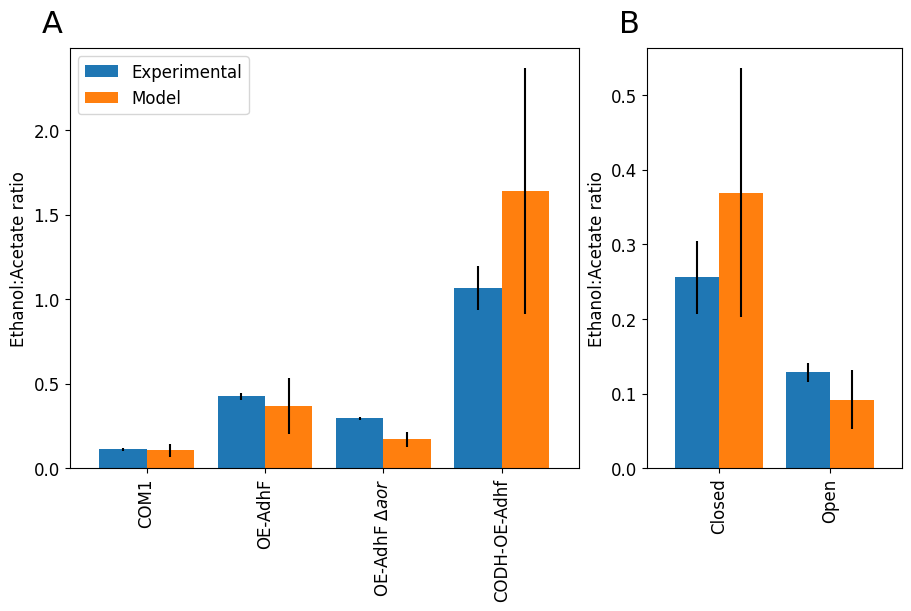

In [9]:
with plt.rc_context({"figure.figsize": (9,6), "font.size": 12}):
    gs_kw = dict(width_ratios=[2, 1])
    fig, axes = plt.subplot_mosaic([["A", "B"]], constrained_layout=True,
                                  gridspec_kw=gs_kw)
    oe_adhf_ethace = (s1_YM_closed_OE.TP_ETOH/s1_YM_closed_OE.TP_ace)
    codh_less_200 = (s_CODH_100.TP_ETOH/s_CODH_100.TP_ace)
    mw004_ethace = (s_MW004_closed.TP_ETOH/s_MW004_closed.TP_ace)
    df1 = pd.DataFrame([
        [0.1108051801, mw004_ethace.median()], # MW004
        [0.4248445655, oe_adhf_ethace.median()], # MW631
        [0.2939348098, np.median(etoh/ace)], #MW647
        [1.06800339, codh_less_200.median()], # MW650 CODH + CO
        ],
        index=["COM1", "OE-AdhF", "OE-AdhF Δ$\it{aor}$", "CODH-OE-Adhf"],
        columns=["Experimental", "Model"]
    )
    yerr = pd.DataFrame([
        [0.00952931562, np.median(mw004_ethace)-np.quantile(mw004_ethace, 0.25)],
        [0.02195005832, np.median(oe_adhf_ethace)-np.quantile(oe_adhf_ethace, 0.25)],
        [0.008670734846, np.median(etoh/ace)-np.quantile(etoh/ace, 0.25)],
        [0.1296990652, np.median(codh_less_200)-np.quantile(codh_less_200, 0.25)],
    ])
    yerr.columns = df1.columns
    yerr.index = df1.index
    df1.plot(kind="bar", yerr=yerr, align="center", width=0.8, ax=axes["A"])
    axes["A"].set_ylabel("Ethanol:Acetate ratio")
    axes["A"].legend(loc="upper left")
    
    # Experimental data from Hailey's open/closed stuff
    ethace_closed = s1_YM_closed_OE.TP_ETOH/s1_YM_closed_OE.TP_ace
    ethace_open = s1_YM_open_OE.TP_ETOH/s1_YM_open_OE.TP_ace
    df2 = pd.DataFrame(
        #[[0.4161, ethace_closed.median()],
        [[0.2556, ethace_closed.median()],
        [0.1284, ethace_open.median()]],
        index=["Closed", "Open"],
        columns=["Experimental", "Model"]
    )
    yerr = pd.DataFrame([
        [0.0494, np.median(ethace_closed)-np.quantile(ethace_closed, 0.25)],
        [0.0124, np.median(ethace_open)-np.quantile(ethace_open, 0.25)]])
    yerr.columns = df2.columns
    yerr.index = df2.index
    df2.plot(kind="bar", yerr=yerr, ax=axes["B"], align="center", width=0.8)
    #plt.ylabel("Ethanol:Acetate ratio")
    axes["B"].set_ylabel("Ethanol:Acetate ratio")
    axes["B"].get_legend().remove()
    #axes["B"].legend(loc="upper right")
    
    ########### A,B,C,D labels
    for label, ax in axes.items():
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize="22", va="bottom", fontfamily="sans")
    plt.savefig("./figures/Fig3.tiff",
               dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

In [50]:
with lzma.open("pickles/s2.pkl.xz", "wb") as f:
    pickle.dump([s_MW004_closed, s_CODH_100], f)

## Figure 4
Percent contribution of key redox compounds
Originally, the open and closed analyses were separate and duplicated efforts, so the the code in the two blocks below is mostly identical. But both must be run for the plot to work.

In [10]:
# we are calculating the percentage of ATP production/consumption
# by each reaction.
cpddict = {"ATP": "C00002", "ADP": "C00008",
           "AMP": "C00020", "GTP": "C00044",
           "GDP": "C00035", "GMP": "C00144",
           "Reduced Ferredoxin": "C00138",
           "NADPH": "C00005", "NADH": "C00004"}

rxn_percents = {}
flux_by_cpd = {}
for cpdname, cpid in cpddict.items():
    rxnlist = getattr(YM_closed.metabolites, cpid).reactions
    coefs = [x.get_coefficient(cpid) for x in rxnlist]
    z = zip([x.id for x in rxnlist], coefs)
    df = pd.DataFrame(list(z)).rename(columns={0: None, 1: "coef"}).set_index(None)
    # fluxes in sample multiplied by the coefficient of their reaction
    s_adjust = s1_YM_closed_OE.T.multiply(df.coef, axis="index")#.dropna() 
    # convert fluxes to percentage of total cpd flux, then avg across samples
    flux_by_cpd[cpdname] = s_adjust
    
# Combining ATP and GTP
flux_by_cpd["ATP"][flux_by_cpd["ATP"].isna()] = 0
flux_by_cpd["GTP"][flux_by_cpd["GTP"].isna()] = 0
ATP_GTP = flux_by_cpd["ATP"].add(flux_by_cpd["GTP"], axis="index")
ATP_GTP = ATP_GTP.loc[(ATP_GTP!=0).any(axis=1)]
#ATP_GTP.apply(axis=0, func=lambda x: x/(sum(abs(x))/2)).apply(axis=1, func=mean)
flux_by_cpd["ATP/GTP"] = ATP_GTP
for key in ["ATP", "GTP", "ADP", "AMP", "GDP", "GMP", "NADH"]:
    del flux_by_cpd[key]

rxn_percents = {key: df.dropna().apply(axis=0, func=lambda x: x/(sum(abs(x))/2)).apply(axis=1, func=mean)
                for key, df in flux_by_cpd.items()}

result = pd.concat(rxn_percents.values(), axis=1)
result.columns = rxn_percents.keys()
result[result.isna()] = 0
result.loc["R00229"] = result.loc["R00229"] + result.loc["R00229_DASH_G"] # combine the ATP and GTP ACS
result.drop(index="R00229_DASH_G", inplace=True)

rxn_name_map = {"R00229": "ACS", "R07159": "GAPOR", "R00200": "PYK",
                "R07181": "SHI", "atps": "ATPS", "R00746": "AdhF",
                "mbh": "MBH", "R01196": "POR", "nfn1": "Nfn1"}
result.rename(index=rxn_name_map, inplace=True)

production = result.copy()
production[production < 0] = 0
othersums = production.apply(axis=0, func=lambda x: x[x<0.1].sum())
production[production < 0.1] = 0
production = production[["ATP/GTP", "Reduced Ferredoxin", "NADPH"]]
production = production.sort_values(["ATP/GTP", "Reduced Ferredoxin", "NADPH"], ascending=False)
production.loc["Other"] = othersums
production = production.loc[(production!=0).any(axis=1)]
production_closed = production.copy()

In [11]:
# we are calculating the percentage of ATP production/consumption
# by each reaction.
cpddict = {"ATP": "C00002", "ADP": "C00008",
           "AMP": "C00020", "GTP": "C00044",
           "GDP": "C00035", "GMP": "C00144",
           "Reduced Ferredoxin": "C00138",
           "NADPH": "C00005", "NADH": "C00004"}

rxn_percents = {}
flux_by_cpd = {}
for cpdname, cpid in cpddict.items():
    rxnlist = getattr(YM_open.metabolites, cpid).reactions
    coefs = [x.get_coefficient(cpid) for x in rxnlist]
    z = zip([x.id for x in rxnlist], coefs)
    df = pd.DataFrame(list(z)).rename(columns={0: None, 1: "coef"}).set_index(None)
    # fluxes in sample multiplied by the coefficient of their reaction
    s_adjust = s1_YM_open_OE.T.multiply(df.coef, axis="index")#.dropna() 
    # convert fluxes to percentage of total cpd flux, then avg across samples
    flux_by_cpd[cpdname] = s_adjust

# Combining ATP and GTP
flux_by_cpd["ATP"][flux_by_cpd["ATP"].isna()] = 0
flux_by_cpd["GTP"][flux_by_cpd["GTP"].isna()] = 0
ATP_GTP = flux_by_cpd["ATP"].add(flux_by_cpd["GTP"], axis="index")
ATP_GTP = ATP_GTP.loc[(ATP_GTP!=0).any(axis=1)]
#ATP_GTP.apply(axis=0, func=lambda x: x/(sum(abs(x))/2)).apply(axis=1, func=mean)
flux_by_cpd["ATP/GTP"] = ATP_GTP
for key in ["ATP", "GTP", "ADP", "AMP", "GDP", "GMP", "NADH"]:
    del flux_by_cpd[key]

rxn_percents = {key: df.dropna().apply(axis=0, func=lambda x: x/(sum(abs(x))/2)).apply(axis=1, func=mean)
                for key, df in flux_by_cpd.items()}

result = pd.concat(rxn_percents.values(), axis=1)
result.columns = rxn_percents.keys()
result[result.isna()] = 0
result.loc["R00229"] = result.loc["R00229"] + result.loc["R00229_DASH_G"] # combine the ATP and GTP ACS
result.drop(index="R00229_DASH_G", inplace=True)

rxn_name_map = {"R00229": "ACS", "R07159": "GAPOR", "R00200": "PYK",
                "R07181": "SHI", "atps": "ATPS", "R00746": "AdhF",
                "mbh": "MBH", "R01196": "POR", "nfn1": "Nfn1"}
result.rename(index=rxn_name_map, inplace=True)

production = result.copy()
production[production < 0] = 0
othersums = production.apply(axis=0, func=lambda x: x[x<0.1].sum())
production[production < 0.1] = 0
production = production[["ATP/GTP", "Reduced Ferredoxin", "NADPH"]]
production = production.sort_values(["ATP/GTP", "Reduced Ferredoxin", "NADPH"], ascending=False)
production.loc["Other"] = othersums
production = production.loc[(production!=0).any(axis=1)]
production_open = production.copy()

In [12]:
production_closed = production_closed.rename(columns={"Reduced Ferredoxin": "Fd$_{red}$"})
production_open = production_open.rename(columns={"Reduced Ferredoxin": "Fd$_{red}$"})

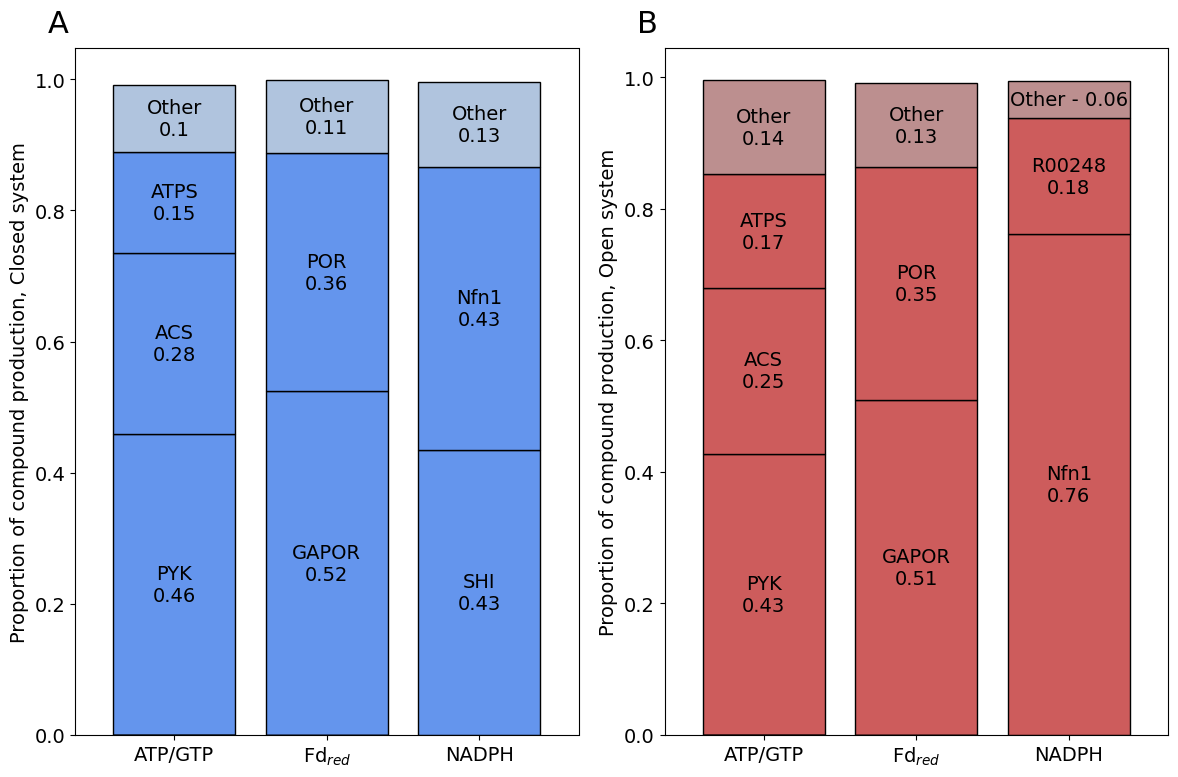

In [13]:
with plt.rc_context({"figure.figsize": (12,8), "font.size": 14}): #(8,14) (6,12)
    fig, axes = plt.subplot_mosaic([["A", "B"]], constrained_layout=False)
    production_closed.T.plot(kind="bar", stacked=True, ax=axes["A"], color=7*["cornflowerblue"]+["lightsteelblue"], linewidth=1, width=0.8, edgecolor="black")
    axes["A"].get_legend().remove()
    axes["A"].set_ylabel("Proportion of compound production, Closed system")
    axes["A"].set_xticklabels(axes["A"].get_xticklabels(), rotation=0)
    #axes["A"].xaxis.set_ticklabels([])
    for c in axes["A"].containers:
        plt.setp(c, linewidth=1)
        labs = len(c.datavalues) * [c.get_label()]
        labs = [l+"\n"+str(round(v,2)) for l,v in zip(labs, c.datavalues)]
        for i, val in enumerate(c.datavalues):
            if val == 0:
                labs[i] = ""
            elif val < 0.08:
                labs[i] = "Other - {}".format(round(val, 2))
        axes["A"].bar_label(c, labels=labs, label_type="center")
    #####
    production_open.T.plot(kind="bar", stacked=True, ax=axes["B"], color=7*["indianred"]+["rosybrown"], linewidth=1, width=0.8, edgecolor="black")
    axes["B"].get_legend().remove()
    axes["B"].set_ylabel("Proportion of compound production, Open system")
    axes["B"].set_xticklabels(axes["B"].get_xticklabels(), rotation=0)
    for c in axes["B"].containers:
        labs = len(c.datavalues) * [c.get_label()]
        labs = [l+"\n"+str(round(v,2)) for l,v in zip(labs, c.datavalues)]
        for i, val in enumerate(c.datavalues):
            if val == 0:
                labs[i] = ""
            elif val < 0.08:
                labs[i] = "Other - {}".format(round(val, 2))
        axes["B"].bar_label(c, labels=labs, label_type="center")
        
    ## Add A and B labels
    for label, ax in axes.items():
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize="22", va="bottom", fontfamily="sans")
        
    plt.tight_layout()
    plt.savefig("figures/Fig4.tiff", dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})